# Perkenalan

* Nama : Kevin Giovanni Pradana
* Batch : 007
* Project : Milestone 2 Phase 1

Dataset yang akan digunakan merupakan dataset prediksi penyakit stroke 

Definisi :
stroke is a disease that affects the arteries leading to and within the brain. It is the No. 5 cause of death and a leading cause of disability in the United States. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or bursts (or ruptures). When that happens, part of the brain cannot get the blood (and oxygen) it needs, so it and brain cells die.

source : https://www.stroke.org/en/about-stroke

|No|column|deskripsi|
|:-|:-|:-|
|1| id| unique identifier|
|2| gender| "Male", "Female" or "Other"|
|3| age| age of the patient|
|4| hypertension| 0 if the patient doesn't have hypertension, 1 if the patient has hypertension|
|5| heart_disease| 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease|
|6| ever_married| "No" or "Yes"|
|7| work_type| "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"|
|8| Residence_type| "Rural" or "Urban" |
|9| avg_glucose_level| average glucose level in blood|
|10| bmi| body mass index|
|11| smoking_status| "formerly smoked", "never smoked", "smokes" or "Unknown"*|
|12| stroke| 1 if the patient had a stroke or 0 if not|


* Note "Unknown" in smoking_status means that the information is unavailable for this patient

# Objective

tujuan milestone ini untuk melatih model agar bisa memprediksi penyakit stroke berdasarkan beberapa parameter seperti diantaranya hipertensi, penyakit jantung, gula darah, berat badan dan merupakan perokok atau bukan

In [1]:
!pip install xgboost

# Import Pustaka

In [2]:
import pandas as pd # for data manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from matplotlib import pyplot
import plotly.graph_objs as go
#from mlxtend.plotting import plot_confusion_matrix

import warnings

#untuk splitting data
from sklearn.model_selection import train_test_split

#untuk encoding and scaling
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#untuk metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve


#from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import make_column_transformer as mct


#for creating pipeline
from sklearn.pipeline import Pipeline, make_pipeline
#from imblearn.pipeline import Pipeline, make_pipeline

import pickle

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
#load dan menampilkan data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


* hypertension : 0 pasien tanpa darah tinggi dan 1 pasien dengan darah tinggi
* heart_disease : 0 untuk pasien tanpa penyakit jantung dan 1 untuk yang memiliki penyakit jantung
* stroke : 0 untuk pasien yang tidak divonis strok dan 1 untuk pasien yang divonis stroke

In [4]:
#melihat info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


* dapat telrihat pada kolom bmi ada missing values dengan asumsi beberapa orang tidak ingin berat badannya diketahui
* untuk nama setiap kolom sudah dalam format yang benar tidak ada yang terpisah dengan spasi

In [5]:
#cek missing values 

df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<AxesSubplot:ylabel='bmi'>

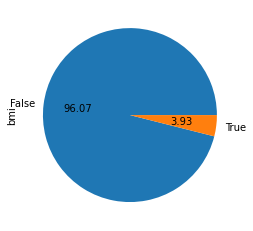

In [6]:
df['bmi'].isnull().value_counts().plot.pie(autopct='%.2f')

terdapat 201 baris missing values di kolom bmi atau sekitar 4% dari keseluruhan data dan akan di handle pada tahapan preprocessing atau ti hapus dengan asumsi 4% dibawah batasan umum 5% sehingga tidak terlalu mengganggu training model nanti

In [7]:
#cek data duplikat
df.duplicated().sum()

0

In [8]:
df = df.drop('id', axis=1)

tidak terdapat data yang bersifat duplikat didalam dataset

# Eksplorasi Data

In [9]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### Gender

In [10]:
#melihat jumlah tiap kategori gender
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

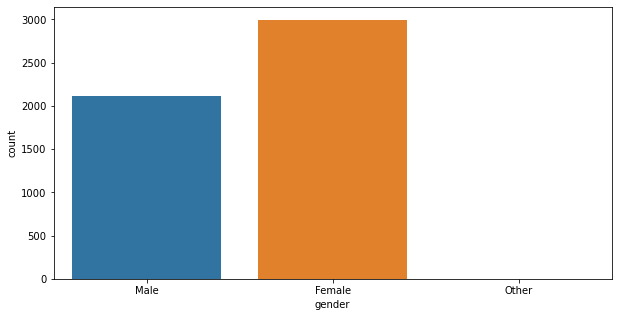

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='gender')

terdapat lebih dari 2000 data pria dan 3000 data perempuan

In [12]:
#visualisasi persentase jenis kelamin
fig = px.pie(df, names='gender', title = 'Distribusi jenis kelamin', width=600, height=400)
fig.show()


data didominasi oleh perempuan dengan 58,6% diikuti 41,4% untuk pria dan terdapat 1 orang yang tidak mencantumkan jenis kelaminnya. kemungkinan hal itu terjadi karena lupa untuk mengisi jenis kelamin dan kemungkinan lainnya karena orang tersebut tidak merasa jenis kelaminnya perempuan ataupun pria

### Age

In [13]:
#menampilkan tiap kategori umur dalam kolom age
df['age'].value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

In [14]:
#melihat umur tertua dan termuda 
df['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

rata-rata umur dalam data yaitu 43 tahun dengan umur tertua 82 tahun dan umur termuda 8 minggu, berarti dataset ini untuk rentang usia bayi hingga lansia. diasumsikan bayi termasuk kedalam dataset tersebut dikarenakan ada penyakit bawaan dari kedua orang tua yang menyebabkan bayi mengidap stroke

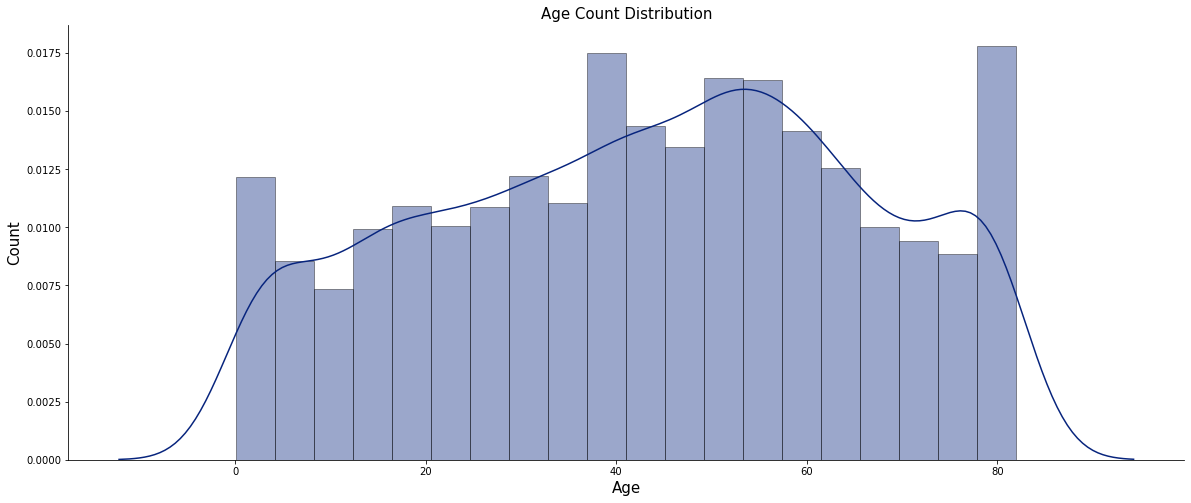

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.distplot(df['age'], hist = True, color = "#07247D", hist_kws = {'edgecolor':'black'})
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Age Count Distribution', fontsize=15)
sns.despine()

persebaran data terlihat merata dengan distribusi data yang banyak pada rentang umur 40 hingga 80 tahun

### Hypertension

In [16]:
df['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [17]:
fig = px.pie(df, names='hypertension', title = 'Distribusi hipertensi', width=600, height=400)
fig.show()

dapat dilihat pengidap hipertensi hanya 9.75% sehingga lebih banyak orang tanpa hipertensi dengan persentase 90,3%

### Heart Disease

In [18]:
df['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

<AxesSubplot:ylabel='heart_disease'>

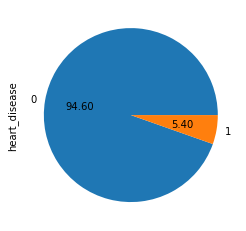

In [19]:
df['heart_disease'].value_counts().plot.pie(autopct='%.2f')

terdapat 4834 orang tanpa penyakit jantung dan 276 orang dengan penyakit jantung atau 5,4% dari total data pasien

### Stroke

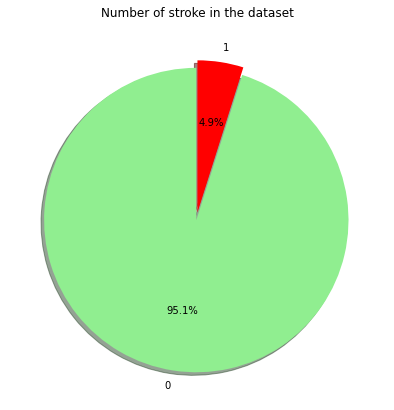

In [20]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)

colors = ["lightgreen","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Number of stroke in the dataset')
plt.show()

berdasarkan visualisasi diatas data label terlihat sangat tidak seimbang dimana hanya 1% orang yang divonis stroke, yang berarti data perlu di sampling sehingga tidak tampak bias

### Stroke berdasarkan tipe pekerjaan

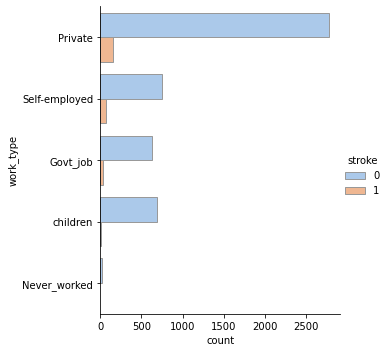

In [21]:
sns.catplot(y="work_type", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)
plt.show()            

dalam hal pekerja orang yang bekerja di sektor private dan self-employed, diasumsikan kedua sektor pekerjaan tersebut menguras otak dan banyak dari mereka tidak melakukan olahraga atau memiliki pola hidup buruk

### Stroke berdasarkan status merokok

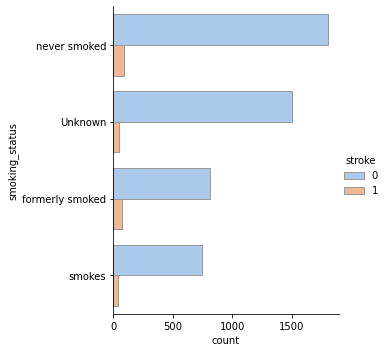

In [22]:
sns.catplot(y="smoking_status", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=df, order=df['smoking_status'].value_counts().sort_values(ascending=False).index)
plt.show()            

berdasarkan grafik diatas didapatkan bahwa ternyata orang yang tidak merokok dan pernah merokok mengidap stroke lebih banyak ketimbang perokok aktif, oleh karena itu status merokok tidak mempengaruhi penyakit stroke 

In [23]:
columns = ['heart_disease','Residence_type','hypertension']

<Figure size 1224x504 with 0 Axes>

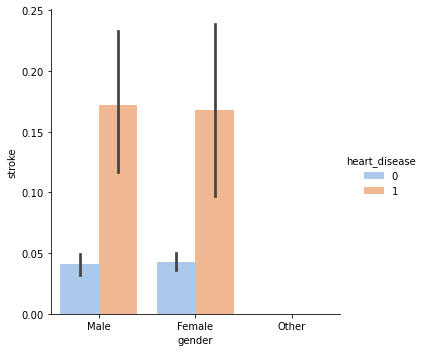

<Figure size 1224x504 with 0 Axes>

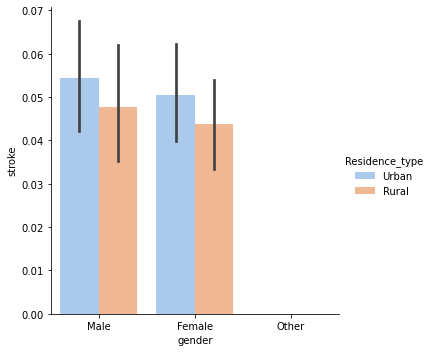

<Figure size 1224x504 with 0 Axes>

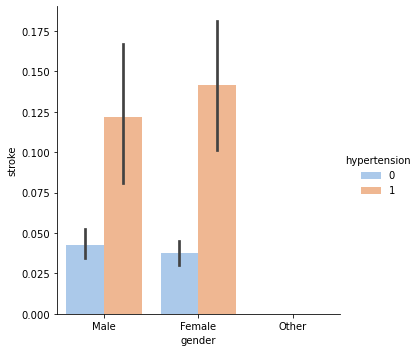

In [24]:
for col in columns:
     plt.figure(figsize=(17,7))
     sns.catplot(x="gender", y="stroke", hue=col, palette="pastel", kind="bar", data=df)
     plt.show()

* dapat dilihat ternyata penyakit jantung dan darah tinggi cukup mempengaruhi terjadinya stroke pada seseorang, dengan darah tinggi penyebab terjadinya lebih banyak stroke bagi perempuan dan penyakit jantung penyebab lebih tinggi stroke bagi pria
* orang-orang yang tinggal di daerah pedesaan (rural) lebih tidak rawan terkena stroke dibanding yang tinggal di perkotaan (urban) dengan asumsi di perkotaan udara tercemar dan makanan sudah bercampur dengan banyak zat berbahaya untuk jangka panjang pada kondisi kesehatan seseorang

#### persebaran stroke dan tidak stroke berdasarkan jenis kelamin

In [25]:
len_data = len(df)
len_w = len(df[df["gender"]=="Male"])
len_m = len_data - len_w

men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke

women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke

labels = ['Men with stroke','Men healthy','Women with stroke','Women healthy']
values = [men_stroke, men_no_stroke, women_stroke, women_no_stroke]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,textinfo='label+percent',hole=0.4)])
fig.update_layout(
    title_text="Distribution of stroke EVENT according to their gender")
fig.show()

terlihat lebih banyak pria yang sehat dibandingkan wanita begitupun yang divonis stroke lebih banyak wanita dibanding pria walaupun hanya berbeda kurang dari 1% 

### Data Distribution

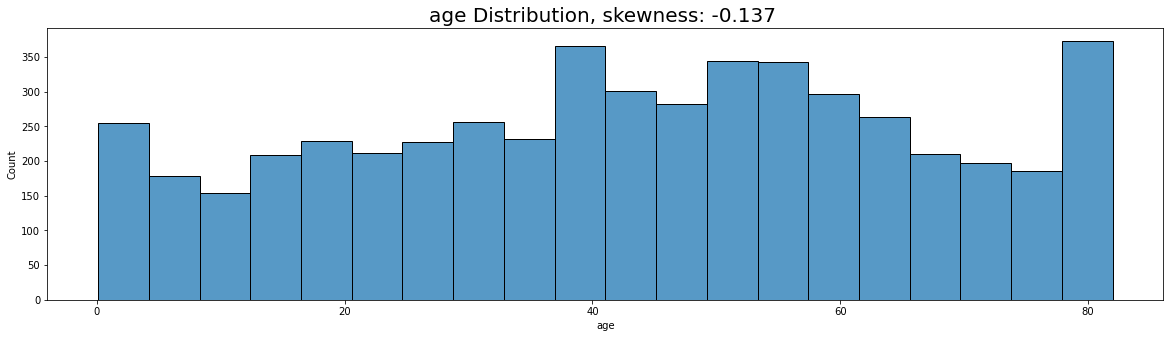

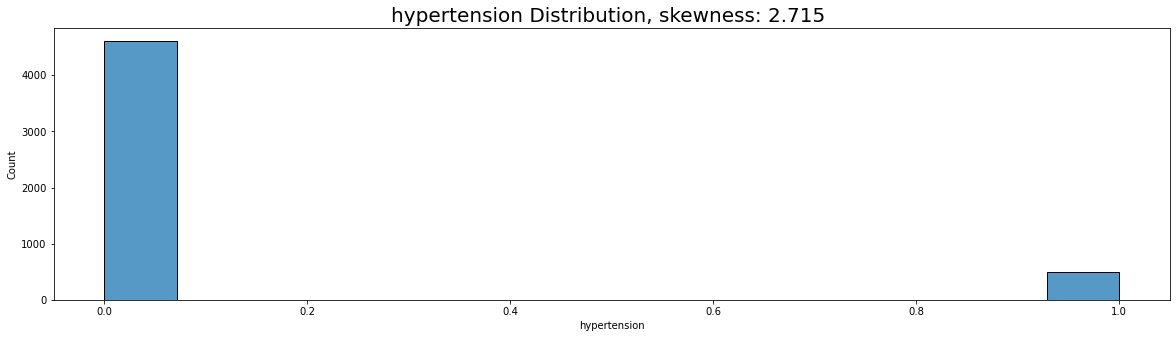

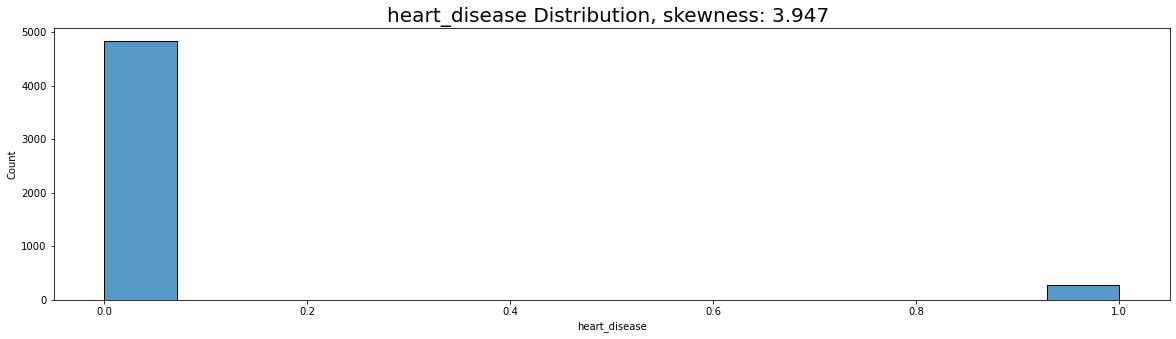

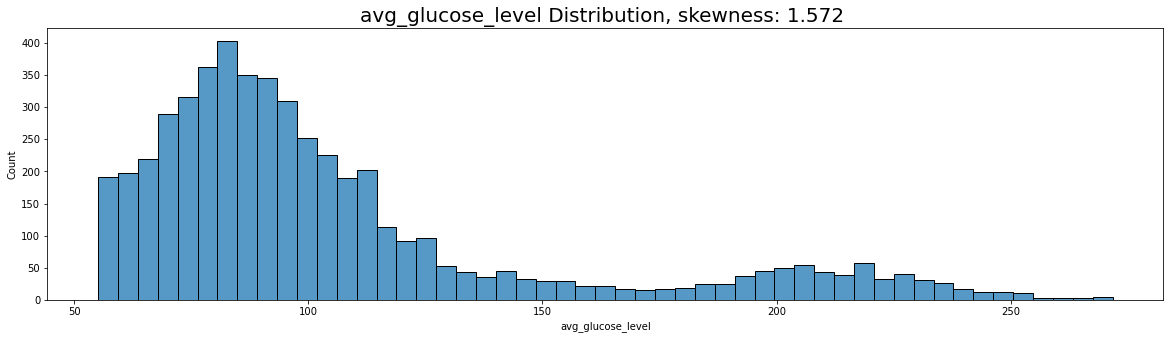

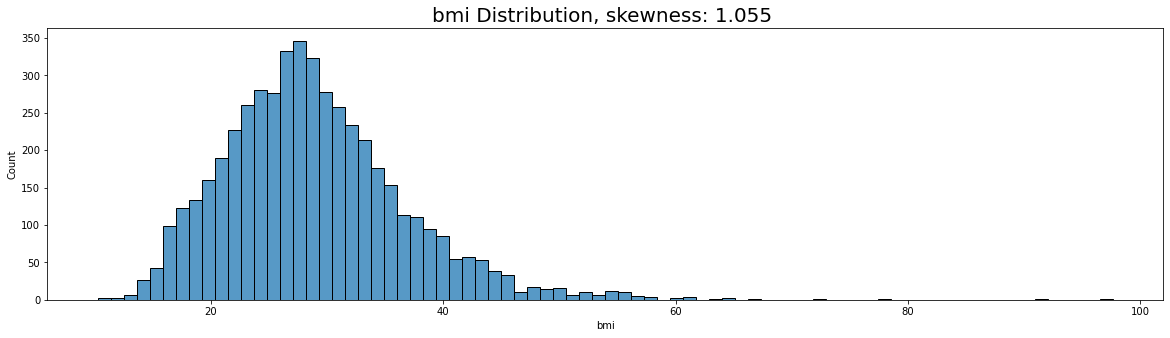

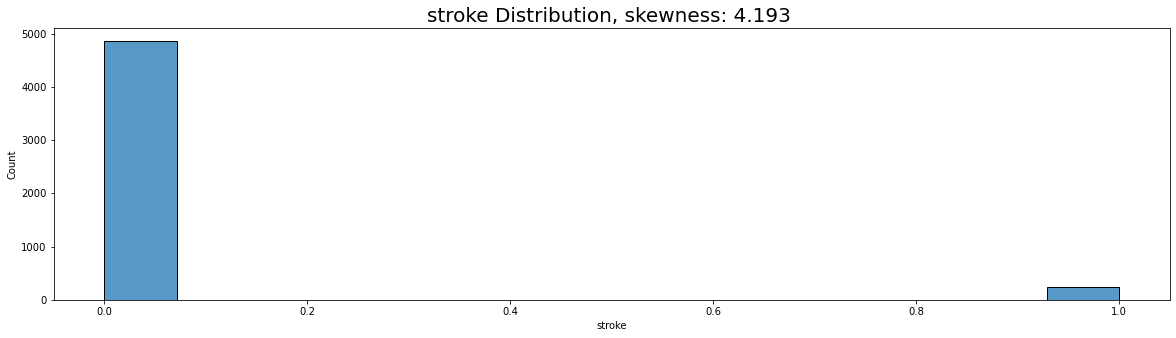

In [26]:
#plot distribusi data semua kolom
for col in df.select_dtypes('number').columns:
    plt.figure(figsize=(20,5))
    plt.title('{} Distribution, skewness: {} '.format(col,str(round(df[col].skew(), 3))), fontsize=20)
    sns.histplot(df[col])
    plt.show()

hampir semua data bersifat skewed oleh, data yang hampir terdistribusi normal hanya data id yang kemungkinan tidak akan digunakan dalam model

#### Outlier

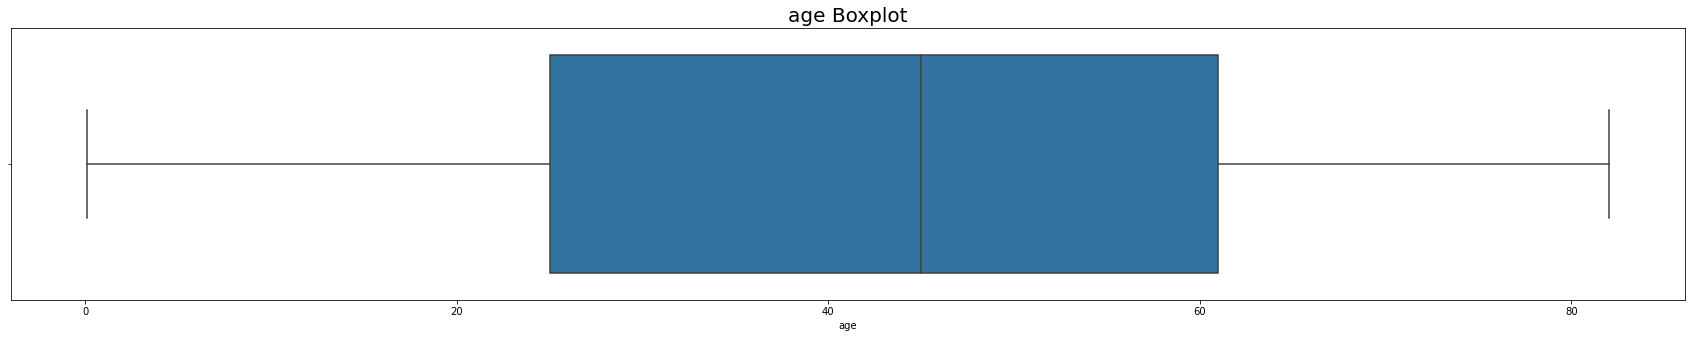

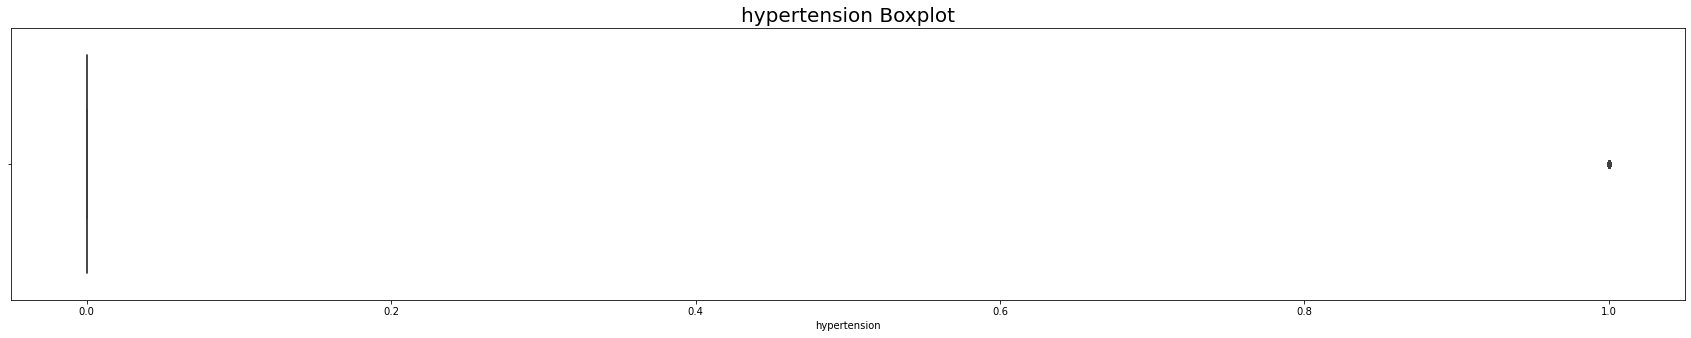

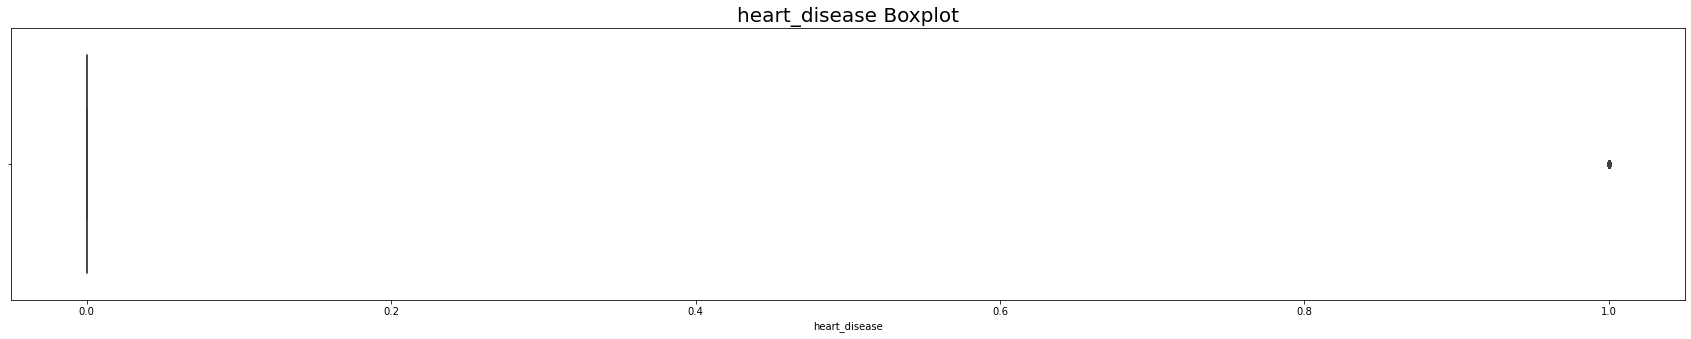

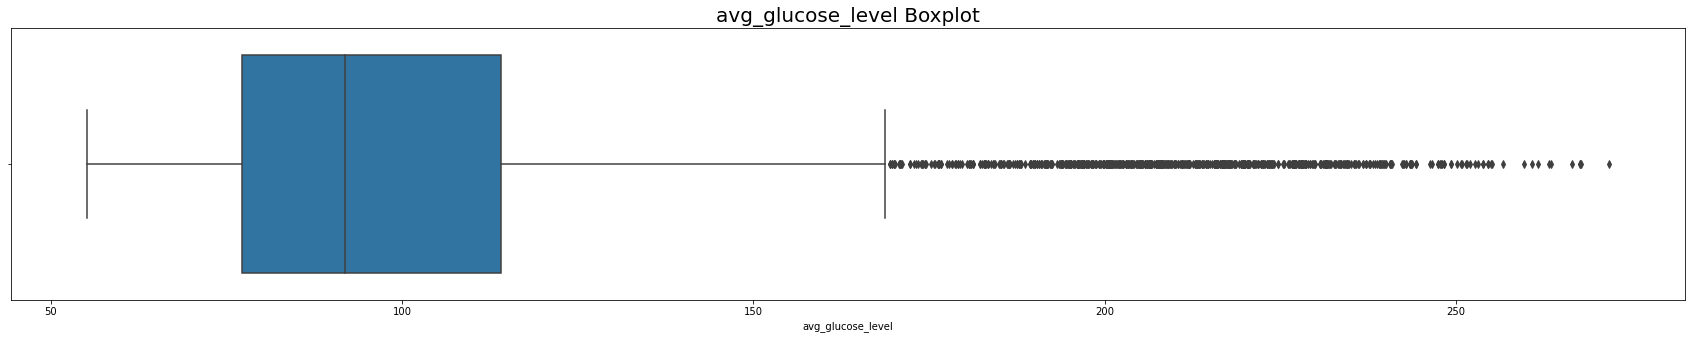

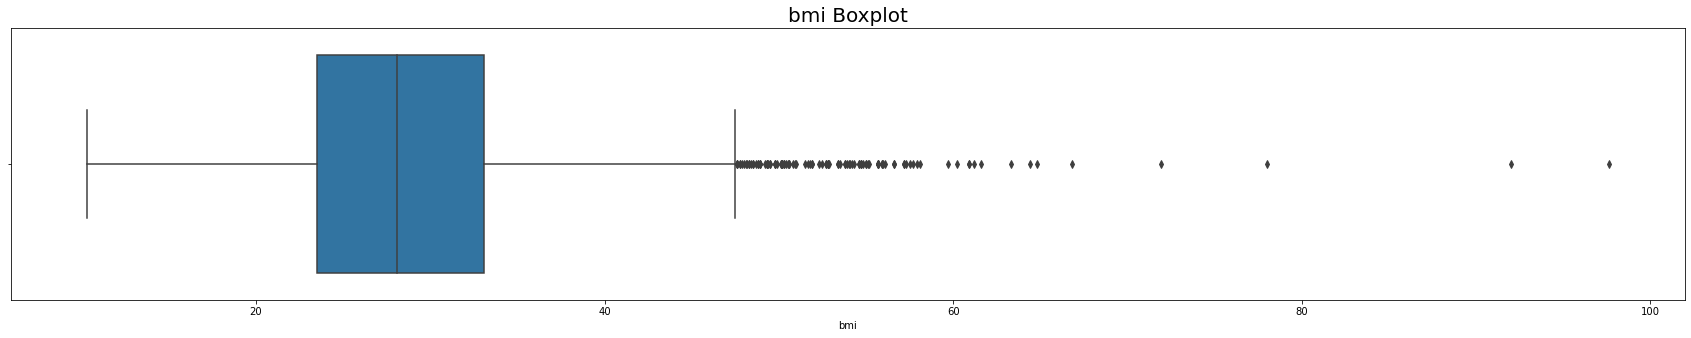

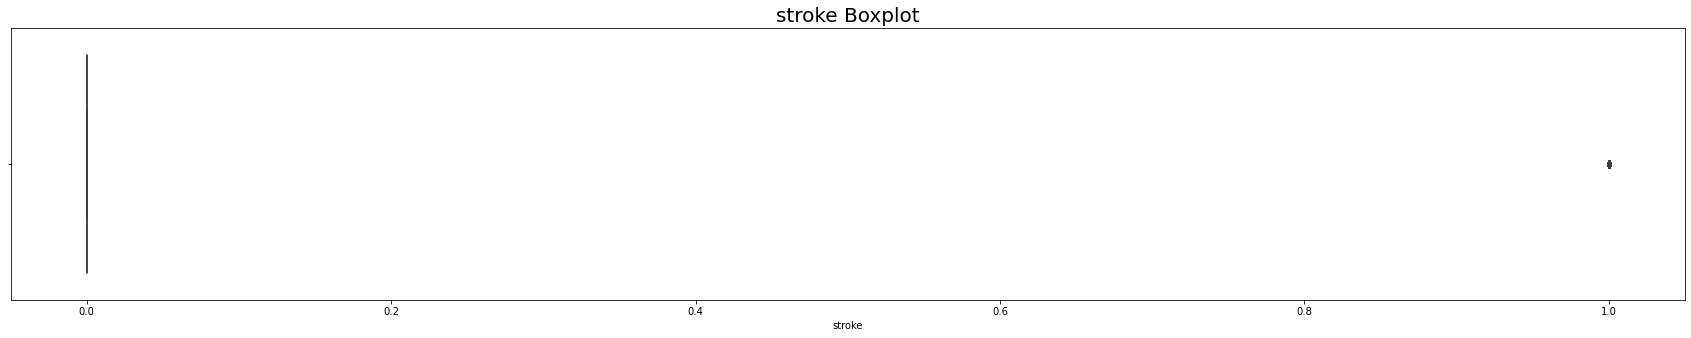

In [27]:
#plot distribusi data dengan boxplot untuk melihat outlier
for column in df.select_dtypes('number').columns:
    plt.figure(figsize=(30,5))
    plt.title('{} Boxplot'.format(column), fontsize = 20)
    sns.boxplot(df[column])
    plt.show()

![alt text](bmi.jpg "BMI range")

* data yang memiliki outlier hanya BMI dan avg_glucose, namun kadar gula darah pada orang diabetes bisa saja sangat tinggi sedangkan BMI kemungkinan bisa dihapus
* sedangkan untuk data stroke, darah tinggi dan penyakit jantung tidak bisa disebut outlier karena memang datanya yang terkena stroke sedikit

### Korelasi

In [28]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


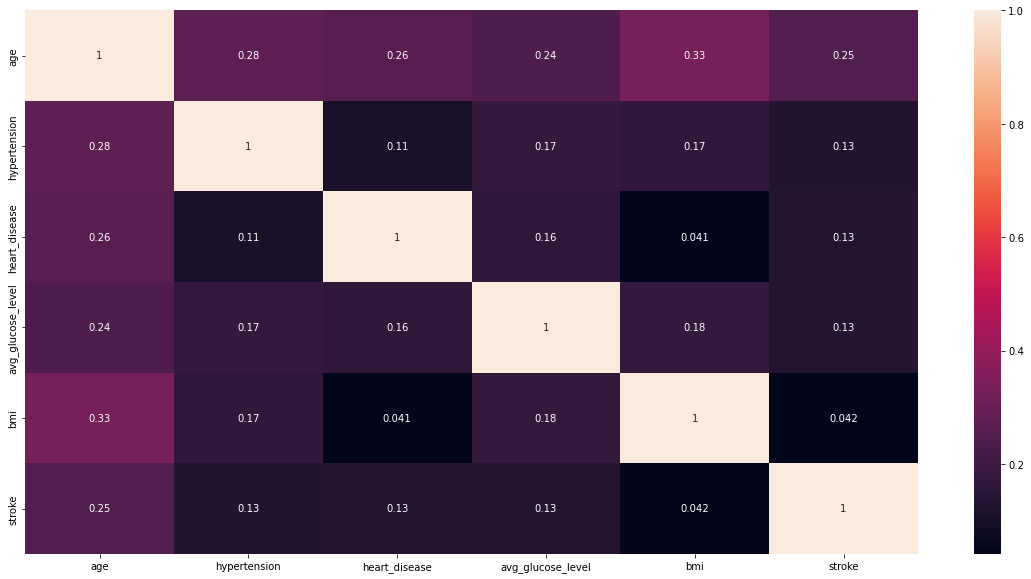

In [29]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True);


# Data Preprocessing

### feature encoding

In [30]:
df = df[df['gender'] != 'Other']

In [31]:
#labelencoding

obj_feat = df.dtypes[df.dtypes == 'O'].index.values
le = LabelEncoder()

for i in obj_feat:
    df[i] = le.fit_transform(df[i])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,NaN,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.6,1,0


### Scaling dan splitting

In [32]:
data = df.copy()

In [33]:
#data['bmi'] = data['bmi'].fillna(df['bmi'].mean())

In [34]:
X = data.drop('stroke', axis=1)
y = data['stroke']

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [35]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4087, 10), (1022, 10), (4087,), (1022,))

### Handle Missing Values

In [36]:
y_train.isnull().sum()

0

In [37]:
X_train.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  156
smoking_status         0
dtype: int64

In [38]:
X_train['bmi'] = X['bmi'].apply(lambda x: 50 if x>50 else x)
X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].median())

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape, X_test.shape

((4087, 10), (1022, 10))

## Definisi dan Pelatihan Model

In [39]:
all_model = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
            RandomForestClassifier(), GradientBoostingClassifier(), SVC(), XGBClassifier()]

recall = []
precision = []
f1=[]
for model in all_model:
    cv = cross_val_score(model, X_train, y_train, scoring='recall', cv=10).mean()
    recall.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='precision', cv=10).mean()
    precision.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='f1', cv=10).mean()
    f1.append(cv)

model = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
         'RandomForestClassifier', 'GradientBoost', 'SVC', 'XGBoost']

score = pd.DataFrame({'Model': model, 'Precision': precision, 'Recall': recall, 'F1':f1})
score.style.background_gradient(high=1,axis=0)

[23:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model,Precision,Recall,F1
0,LogisticRegression,0.000000,0.000000,0.000000
1,KNeighborsClassifier,0.150000,0.010526,0.019524
2,DecisionTreeClassifier,0.140129,0.165000,0.156170
3,RandomForestClassifier,0.000000,0.000000,0.019524
4,GradientBoost,0.183333,0.020526,0.027706
5,SVC,0.000000,0.000000,0.000000
6,XGBoost,0.120000,0.030789,0.048747


## Definisi dan Pelatihan Model dengan data balance

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
#X_bal, Y_bal = smote.fit_resample(X, y)
#X_train, X_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=11)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [42]:
#outlier
X_train['bmi'] = X['bmi'].apply(lambda x: 50 if x>50 else x)
#missing values
X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].median())


#scaling
sc = StandardScaler()
X_train_bal = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_bal, y_train_bal = smote.fit_resample(X_train,y_train)


X_train_bal.shape, X_test.shape

((7786, 10), (1022, 10))

In [43]:
#definisi tiap model pembanding
all_model = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
            RandomForestClassifier(), GradientBoostingClassifier(), SVC(), XGBClassifier()]

#membuat list kosong untuk menyimpan hasil perhitungan cross validation dibawah
recall = []
precision = []
f1=[]
balanced_accuracy=[]


for model in all_model:
    cv = cross_val_score(model, X_train_bal, y_train_bal, scoring='recall', cv=10).mean()
    recall.append(cv)
    
    cv = cross_val_score(model, X_train_bal, y_train_bal, scoring='precision', cv=10).mean()
    precision.append(cv)
    
    cv = cross_val_score(model, X_train_bal, y_train_bal, scoring='f1', cv=10).mean()
    f1.append(cv)
    
    cv = cross_val_score(model, X_train_bal, y_train_bal, scoring='balanced_accuracy', cv=10).mean()
    balanced_accuracy.append(cv)

model = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
         'RandomForestClassifier', 'GradientBoost', 'SVC', 'XGBoost']

score = pd.DataFrame({'Model': model, 'Precision': precision, 'Recall': recall, 'F1':f1, 'balanced_accuracy':balanced_accuracy})
score.style.background_gradient(high=1,axis=0)

[23:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model,Precision,Recall,F1,balanced_accuracy
0,LogisticRegression,0.762854,0.824306,0.792168,0.783846
1,KNeighborsClassifier,0.851315,0.991010,0.915798,0.908811
2,DecisionTreeClassifier,0.909437,0.930374,0.919773,0.917795
3,RandomForestClassifier,0.960428,0.974559,0.965060,0.964031
4,GradientBoost,0.899216,0.923696,0.909651,0.910090
5,SVC,0.805428,0.920367,0.858991,0.848957
6,XGBoost,0.973791,0.946794,0.953649,0.960295


* Berdasarkan Baseline Hasil Training model dan Metric diatas, didapatkan bahwa data yang telah di oversampling menghasilkan f1 score yang lebih jelas dan lebih baik dibandingkan dengan data tanpa oversampling.
* Berdasarkan hasil perbandingan f1 score dan balanced accuracy, maka didapatkan model RandomForest menjadi model yang terbaik dengan nilai FN yang cukup rendah


### Melihat performa randomforest pada data test

In [44]:
#splitting
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=11)

In [45]:
#outlier
Xtrain['bmi'] = X['bmi'].apply(lambda x: 50 if x>50 else x)
#missing values
Xtrain['bmi'] = Xtrain['bmi'].fillna(Xtrain['bmi'].median())

Xtest['bmi'] =  Xtest['bmi'].fillna(Xtest['bmi'].median())


#scaling
sc = StandardScaler()
Xtrain_bal = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

#oversampling
Xtrain_bal, ytrain_bal = smote.fit_resample(Xtrain,y_train)

Xtrain_bal.shape, Xtest.shape

((7786, 10), (1022, 10))

In [46]:
#definisikan model
model_1 = RandomForestClassifier(random_state=1)

# Train model 
model_1.fit(Xtrain_bal, ytrain_bal)
pred = model_1.predict(Xtest)

print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       967
           1       0.14      0.58      0.23        55

    accuracy                           0.79      1022
   macro avg       0.56      0.69      0.55      1022
weighted avg       0.93      0.79      0.84      1022



<AxesSubplot:>

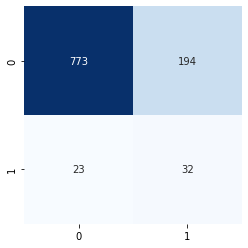

In [47]:
#menampilkan confusion matrix
conf_mat = confusion_matrix(ytest, pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

* dapat dilihat model randomforest sudah cukup baik dalam menekan angka false negative (faktanya stroke namun tidak terdeteksi stroke) karena pada percobaan baseline model didapatkan nilai recall yang paling mendekati 1 yaitu randomforest
* disini difokuskan untuk mereduksi recall karena dapat menyebabkan korban jiwa sedangkan precision perlu juga direduksi namun asumsinya orang yang tidak stroke namun divonis stroke masih bisa melakukan konsultasi di beberapa rumah sakit lainnya untuk mengetahui apakah memang benar mereka terkena stroke atau tidak (jika kondisi stroke ringan)

mecoba baseline model dengan pipeline

In [48]:
x1 = df[df.columns[:-1]]
y1 = df[df.columns[-1]]

xtrain1,xtest1,ytrain1,ytest1 = train_test_split(x1,y1, test_size = .2,stratify = y,random_state = 42)

In [49]:
pipe = Pipeline([('impute', SimpleImputer(strategy='median')),("scaler", StandardScaler()), ("svm", LogisticRegression())])


In [50]:

pipe.fit(xtrain1,ytrain1)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('svm', LogisticRegression())])

#### train model using pipeline

In [51]:
#trainin modul tanpa smote
model_rf = RandomForestClassifier()
x_try = data[data.columns[:-1]]
y_try = data[data.columns[-1]]
xtrain,xtest,ytrain,ytest = train_test_split(x_try,y_try, test_size = .2,stratify = y,random_state = 42)
pipe = Pipeline([('impute', SimpleImputer(strategy='median')),
                ('scale',StandardScaler()),
                ('model',model_rf)])
                #('smote', SMOTE(random_state=11)),
                #('model',model_rf)])
pipe.fit(xtrain,ytrain)
ypred = pipe.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022



In [52]:
#training model dengan smote
model_rf = RandomForestClassifier()
x_try1 = data[data.columns[:-1]]
y_try1 = data[data.columns[-1]]
xtrain11,xtest11,ytrain11,ytest11 = train_test_split(x_try1,y_try1, test_size = .2,stratify = y,random_state = 42)
#xtrain11, ytrain11 = smote.fit_resample(xtrain11, ytrain11)
pipe = Pipeline([('impute', SimpleImputer(strategy='median')),
                ('scale',StandardScaler()),
                #('smote', SMOTE()),
                ('model',model_rf)])
pipe.fit(xtrain11,ytrain11)
ypred = pipe.predict(xtest11)
print(classification_report(ytest11,ypred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### GridSearch

In [53]:
#cek parameter yang bisa dipakai untuk model_rf
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'impute', 'scale', 'model', 'impute__add_indicator', 'impute__copy', 'impute__fill_value', 'impute__missing_values', 'impute__strategy', 'impute__verbose', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'model__bootstrap', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

In [54]:
#set parameter untuk gridsearch
n_estimators = [int(x) for x in np.linspace(start=200, stop=100, num = 2)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, 2)]
param = {'n_estimators': n_estimators,
        'max_features':max_features,
        'max_depth':max_depth,
        'min_samples_split':[5,10],
        'min_samples_leaf':[1, 2]
        }


In [55]:
#cek parameter yang bisa digunakan untuk model_1
model_1.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [56]:
#input missing values dengan median
x_try1['bmi'] = x_try1['bmi'].fillna(x_try1['bmi'].median())

In [57]:
#grid search dengan model tanpa pipeline, karena dengan pipeline tidak selesai running hingga 30 menit
rf_grid= GridSearchCV(estimator=model_1, param_grid=param, cv = 5,n_jobs=1,verbose=2)
rf_grid.fit(x_try1,y_try1)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=1,
             param_grid={'max_depth': [10, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 10],
                         'n_estimators': [200, 100]},
             verbose=2)

In [58]:
#cek parameter terbaik (dengan parameter secukupnya)
rf_grid.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=1)

digunakan model training awal karena menggunakan pipeline tidak selesai-selesai running

# Model Inference

In [59]:
#coba model randomforest dengan data baru dan data lama
model_rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=1 )
x = data[data.columns[:-1]]
y = data[data.columns[-1]]
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size = .2,stratify = y,random_state = 42)
#xtrain11, ytrain11 = smote.fit_resample(xtrain11, ytrain11)
pipe = Pipeline([('impute', SimpleImputer(strategy='median')),
                ('scale',StandardScaler()),
                #('smote', SMOTE()),
                ('model',model_rf)])
pipe.fit(xtrain,ytrain)
ypred = pipe.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



In [60]:
#data lama
strk = data.sample(1,random_state = 23)
strk = strk.drop('stroke',axis=1)
strk

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
2095,0,68.0,0,0,1,2,0,97.96,31.3,2


In [61]:
#data baru
strk1 = [[1,10,0,0,0,3,1,50,30,1]]
strk1 = pd.DataFrame(strk1)
strk1

,0,1,2,3,4,5,6,7,8,9
0,1,10,0,0,0,3,1,50,30,1


In [62]:
#cek model
if pipe.predict(strk1) == 1:
    print("kamu aman dari stroke")
else:
    print("kamu kemungkinan memiliki gejala stroke atau mengalami stroke")

kamu kemungkinan memiliki gejala stroke atau mengalami stroke


model berhasil memprediksi data sample dari data original 

# Model Untuk Deployment

In [63]:
model_rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=1 )
x = data[data.columns[:-1]]
y = data[data.columns[-1]]
#xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size = .2,stratify = y,random_state = 42)
pipe = Pipeline([('impute', SimpleImputer(strategy='median')),
                ('scale',StandardScaler()),
                #('smote', SMOTE()),
                ('model',model_rf)])
pipe.fit(x,y)
with open('model.pkl','wb') as filename:
    pickle.dump(pipe,filename)

# Kesimpulan 

**Data Analisis**
* Penyakit Stroke diakibatkan oleh penyakit jantung dan darah tinggi
* sedangkan status merokok ternyata tidak mempengaruhi terjadinya stroke karena orang tanpa rokok pun bisa terkena stroke
* semakin tua seseorang maka semakin rentan terhadap stroke


**Model**
* berdasarkan training model, didapatkan randomforest sebagai model terbaik 
* dengan nilai precision dan recall mendekati 1 

**Kendala**
* pengerjaan model ini masih dapat diperbaiki dengan cara training menggunakan smote (oversampling) dan beberapa kali saat training terdapat hambatan seperti penggunaan library imblearn yang malah membuat program error